# Anomaly Detection using Autoencoders

## Topic

In this notebook I will experiment with neural networks to classify bank transactions as fraudulent or not. The neural net I will be using is the autoencoder which is a simple network that learns to recreate its input, its performance is measured with the error between the actual input and the input recreated by the autoencoder. After data preprocessing, the autoencoder is only fed with the non fraudulent instances until the error is minimized as much as possible, then the autoencoder is fed fraudulent instances for which the error will be higher than the non fraudulent instances that it has learned to recreate, and that's how we can classify an instance as fraud or not. So let's get started !

## Objective

- Create a network that is able to classify a transaction as a fraud or not

## Summary

- Importing libraries
- The dataset
- Data preprocessing
- Creating the data loader
- Creating the Autoencoder
- Training the network
- Network evaluation
- Testing the network
- Evaluation metrics
- Conclusion

### Importing libraries

In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

### The dataset

In [425]:
df = pd.read_csv(r'C:\Users\imane\Downloads\archive (38)\card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


So the dataset is composed of 7 columns each representing a ratio that has already been calculated, it's composed of :

- distance_from_home - the distance from home where the transaction happened.

- distance_from_last_transaction - the distance from last transaction happened.

- ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.

- repeat_retailer - Is the transaction happened from same retailer.

- used_chip - Is the transaction through chip (credit card).

- used_pin_number - Is the transaction happened by using PIN number.

- online_order - Is the transaction an online order.

- fraud - Is the transaction fraudulent.

In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


<Axes: >

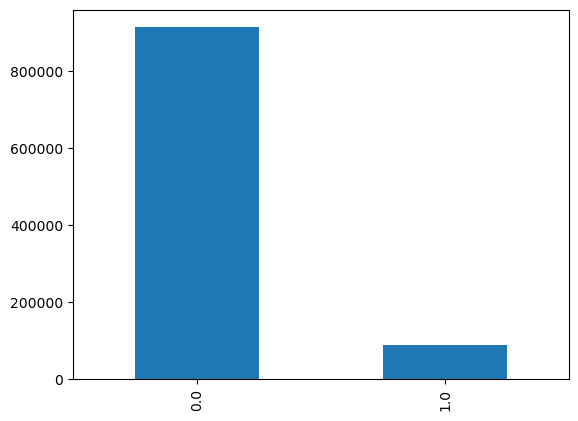

In [427]:
df['fraud'].value_counts().plot(kind='bar')

The plot above shows the amount of fraudulent and regular transactions, as expected the number of regular transaction is much much higher than the fraudulent ones.

### Data preprocessing

In [428]:
regular = df.loc[df['fraud'] == 0.0]
fraud = df.loc[df["fraud"] == 1.0]

In [429]:
print(len(fraud))

87403


In [430]:
print(len(regular))

912597


So first of all I seperated the fraud instances from the regular transaction instances and saved them in seperate datasets.

In [431]:
val_fraud = fraud.iloc[:17480]

In [432]:
fraud = fraud[17480:]
print(len(fraud))

69923


Than I kept 20% of the fraud dataset for validation to be used later on.

In [433]:
test_regular = regular.iloc[:69923]
regular = regular.iloc[69923:]

In [434]:
print(len(regular))

842674


Then I kept a part of the regular transactions to be added to the fraudulent transactions dataset for final testing.

In [435]:
datasets = [fraud, test_regular]
test_df = pd.concat(datasets)

In [436]:
print(len(test_df))

139846


In [437]:
test = shuffle(test_df)
test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
524826,5.700407,1.342965,6.805418,1.0,0.0,0.0,1.0,1.0
69235,4.932474,0.878688,0.310905,1.0,1.0,0.0,1.0,0.0
850925,116.065338,2.420946,1.333897,1.0,0.0,0.0,1.0,1.0
256099,1.454756,5.878092,4.658602,0.0,0.0,0.0,1.0,1.0
501611,47.038781,2.119076,6.194079,1.0,0.0,0.0,1.0,1.0


Then I cancatenated the fraud test portion with the reguklar test portion to get a test dataset where the number of fraudulent transations is the same as the number of regular transactions.

In [438]:
y_train = regular["fraud"]
train = regular.drop(columns=['fraud'], axis=1)

In [439]:
y_test = test['fraud']
test = test.drop(columns=["fraud"], axis=1)

In [440]:
y_val = val_fraud["fraud"]
val = val_fraud.drop(columns=["fraud"], axis= 1)

In [441]:
scaler = MinMaxScaler()
fit = scaler.fit(train)
scaled_train = fit.transform(train)

In [442]:
fit = scaler.fit(test)
scaled_test = fit.transform(test)

In [443]:
fit = scaler.fit(val)
scaled_val = fit.transform(val)

Next I used the MinMax scaler to scale the values I have in all my datasets (training, validation and testing).

### Creating the dataloader

In [444]:
y_train = y_train.to_numpy()

In [445]:
class Train_loader(Dataset):
    def __init__(self):
        self.X = torch.tensor(scaled_train, dtype= torch.float32)
        self.Y = torch.tensor(y_train, dtype = torch.float32)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [446]:
train_data = Train_loader()

In [447]:
train_loader = DataLoader(dataset = train_data, batch_size= 64, drop_last=True)

In [448]:
batch_size = 128
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In the above I created the tensor dataset and the data loader for the training set, and chose a batch size of 128.

### Creating the Autoencoder

In [470]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 365),
            nn.ReLU(),
            nn.Linear(365, 365),
            nn.ReLU(),
            nn.Linear(365, 22),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(22, 365),
            nn.ReLU(),
            nn.Linear(365, 365),
            nn.ReLU(),
            nn.Linear(365, 7),
            nn.ReLU())
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [471]:
autoencoder = autoencoder()
print(autoencoder)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=365, bias=True)
    (1): ReLU()
    (2): Linear(in_features=365, out_features=365, bias=True)
    (3): ReLU()
    (4): Linear(in_features=365, out_features=22, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=22, out_features=365, bias=True)
    (1): ReLU()
    (2): Linear(in_features=365, out_features=365, bias=True)
    (3): ReLU()
    (4): Linear(in_features=365, out_features=7, bias=True)
    (5): ReLU()
  )
)


So the autoencoder is a simple network composed of dully connected layers, it has two parts : the encoder and the decoder. The encoder's job is to learn the distribution and latent factors or features of the instance, and the decoder's job is to rebuild the input fed to the encoder from the latent features generated by the encoder.

### Training the network

In [472]:
criterion = nn.MSELoss()
lr = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
epochs = 15

In [473]:
train_loss = []
autoencoder.train()
for epoch in range(epochs):
    loss = 0.0
    for x, _ in train_loader:
        optimizer.zero_grad()
        y = autoencoder(x)
        l = criterion(x, y)
        loss += l.item()
        l.backward()
        optimizer.step()
    train_loss.append(loss/len(train_loader))
    lo = loss/len(train_loader)
    print("epoch ", epoch+1, "training loss ", lo)

epoch  1 training loss  0.0011439221883898336
epoch  2 training loss  3.30873529747277e-05
epoch  3 training loss  2.5239437137009946e-05
epoch  4 training loss  2.2964671875112867e-05
epoch  5 training loss  2.0745794140365412e-05
epoch  6 training loss  2.2696013639856457e-05
epoch  7 training loss  2.1538621462966333e-05
epoch  8 training loss  1.9174421551307977e-05
epoch  9 training loss  1.9324054932812798e-05
epoch  10 training loss  2.061108197715505e-05
epoch  11 training loss  1.931958009066937e-05
epoch  12 training loss  1.9715869760990955e-05
epoch  13 training loss  1.8606664612410158e-05
epoch  14 training loss  1.874010584947887e-05
epoch  15 training loss  1.9031803663428854e-05


So in the training step I pass a batch through the network which means that the autoencoder outputs its recreation of the input fed to it. I then calculate the error between the actual input and the autoencoder's representation of it. As we can see the error is getting lower which means that the network is learning to recreate the input.

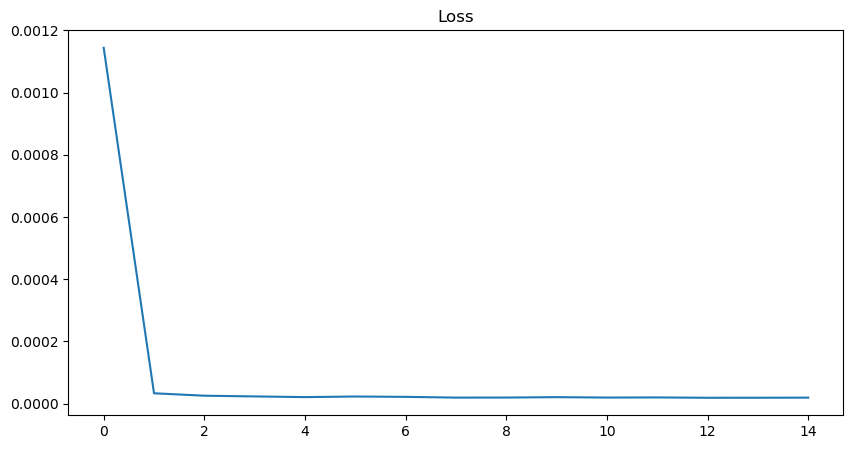

In [474]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(train_loss)

The plot above shows how the error decreses after the first epoch and stays very low for the rest of the epochs.

### Network evaluation

In [475]:
autoencoder.eval()
val_losses = []
for i in scaled_val:
    x = torch.tensor(i, dtype= torch.float32)
    y = autoencoder(x)
    loss = criterion(x, y)
    val_losses.append(loss.item())

For the evaluation part I chose the dataset that contains only fraudulent transactions to see how the network performs on them and to be able to set the threshold which will help me decide if a transaction is a fraud or not later in the testing step.

In [476]:
df_loss = pd.DataFrame()
df_loss["loss"] = val_losses
df_loss.describe()

,loss
count,17480.000000
mean,0.000380
std,0.002644
min,0.000032
25%,0.000062
50%,0.000114
75%,0.000245
max,0.142882


So after passing a number of fraudulent transactions through the autoencoder, I got errors for each instance, above is the description of the errors, I can see that the minimum error for a fraud is 0.000032 i.e all fraudulent transations score an error higher that that. So the minimun error is going to be my threshold.

### Testing the network

In [477]:
autoencoder.eval()
test_losses = []
for i in scaled_test:
    x = torch.tensor(i, dtype= torch.float32)
    y = autoencoder(x)
    loss = criterion(x, y)
    test_losses.append(loss.item())

In [478]:
threshold = 0.000032

So now I used the autoencoder on the test set whoch contains an equal amout of regular and fraudulent transactions. I also set up the threshold to the minimun of the evaluation error.

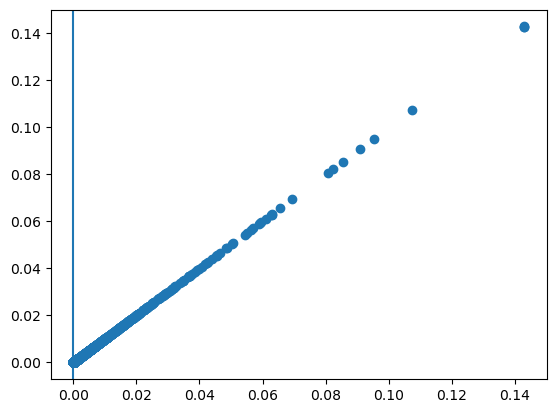

In [484]:
loss_sc = []
for i in test_losses:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(threshold, 0.0, 1)

In [480]:
targets = []
for i in test_losses:
    if i <= threshold:
        targets.append(0)
    elif i > threshold:
        targets.append(1)

Finally I stored the targets in a list where the transations that have an error below the threshold are considered regular transations and the ones that have an error higher than the threshold are considered fraudulent.

### Performance metrics

In [481]:
cm = confusion_matrix(y_test, targets)

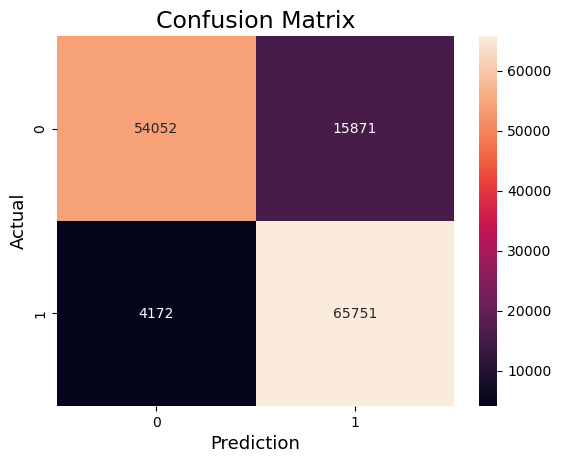

In [482]:
sns.heatmap(cm, 
            annot=True,
            fmt='g', )
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [483]:
print(classification_report(y_test, targets))

              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84     69923
         1.0       0.81      0.94      0.87     69923

    accuracy                           0.86    139846
   macro avg       0.87      0.86      0.86    139846
weighted avg       0.87      0.86      0.86    139846



In the above I calculated and ploted the confusion matrix as well as the classification report, the results are not perfect in terms of detecting all fraudulent transactions but as the recall shows the network is able to detect 94% of the fraudulent transactions.

## Conclusion

In this notebook I had the opportunity to experiment with anomaly detection using neural nets. I used an autoencoder to learn the latent factors of the regular transations until the error drops to a very low level, then I used the same network on fraudulent transactions to be able to set a threshold. Finally I tested my network on a dataset that contains both fraudulent and non fraudulent transaction and the results were above average. So I can say I'm happy with my model's performance.